In [14]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras import Model

# Autoencoder

In [15]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path)
        img = img.convert('L')  # Ensure the image is in gray format
        img = img.resize((128, 128))  # Resize image to a fixed size
        img_array = np.array(img)
        images.append(img_array)
    return np.array(images)


# Paths to the image directories
xpath = '../allblackwhite'
ypath = '../pymatting_outcome_rw'

# Load images
x_images = load_images_from_folder(xpath)
y_images = load_images_from_folder(ypath)

# Normalize the images
x_images = x_images.astype('float32') / 255.0
y_images = y_images.astype('float32') / 255.0

# Shuffle and split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_images, y_images, test_size=0.5, random_state=42)

# Verify the shapes of the datasets
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (150, 128, 128)
x_test shape: (151, 128, 128)
y_train shape: (150, 128, 128)
y_test shape: (151, 128, 128)


In [27]:
from tensorflow import keras
latent_dim = 256

class Autoencoder(Model):
    def __init__(self, latent_dim, name="autoencoder",**kwargs):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(128*128, activation='sigmoid'),
            layers.Reshape((128, 128))
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def get_config(self):
        # Return the config of the model, including relevant hyperparameters
        config = super().get_config()
        config.update({
            "latent_dim": self.latent_dim
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create an instance from config
        return cls(**config)

autoencoder = Autoencoder(latent_dim)

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(),metrics=[keras.metrics.BinaryIoU(
        target_class_ids=[0],
        threshold=0.1
    )])
history=autoencoder.fit(x_train, y_train,
                epochs=100,
                shuffle=True,
                validation_data=(x_test, y_test))

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - binary_io_u_2: 0.1601 - loss: 0.1615 - val_binary_io_u_2: 0.9333 - val_loss: 0.0219
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - binary_io_u_2: 0.9306 - loss: 0.0204 - val_binary_io_u_2: 0.9304 - val_loss: 0.0213
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - binary_io_u_2: 0.9285 - loss: 0.0209 - val_binary_io_u_2: 0.9268 - val_loss: 0.0203
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - binary_io_u_2: 0.9269 - loss: 0.0185 - val_binary_io_u_2: 0.9281 - val_loss: 0.0191
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - binary_io_u_2: 0.9290 - loss: 0.0172 - val_binary_io_u_2: 0.9316 - val_loss: 0.0180
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - binary_io_u_2: 0.9331 - loss: 0.0164 - val_binary_io_u_2: 0.9317 - val_loss: 0.0171
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - binary_io_u_2: 0.9342 - loss: 0.0154 - val_binary_io_u_2: 0.9333 - val_loss: 0.0166
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━

In [17]:
from tensorflow import keras
autoencoder.save('../saved_model.keras')
new_model = keras.models.load_model('../saved_model.keras',custom_objects={"Autoencoder": Autoencoder})



In [18]:
encoded_imgs = new_model.encoder(x_test).numpy()
decoded_imgs = new_model.decoder(encoded_imgs).numpy()


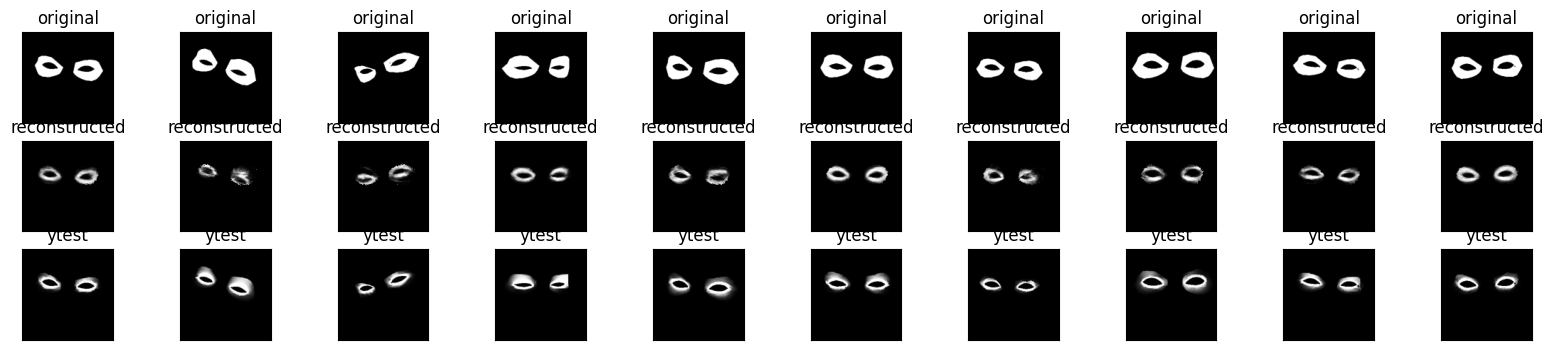

In [19]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(y_test[i])
    plt.title("ytest")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

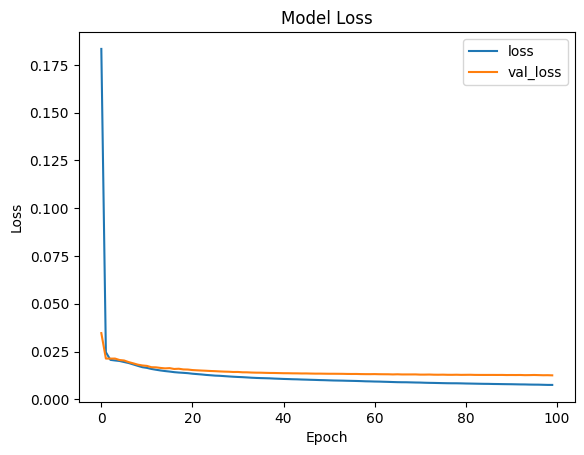

5/5 - 0s - 58ms/step - binary_io_u_1: 0.9706 - loss: 0.0125
Test accuracy: 0.970557689666748


In [20]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(loc='upper right')
plt.show()


test_loss, test_acc = new_model.evaluate(x_test, y_test,verbose=2,)

print(f'Test accuracy: {test_acc}')

# Autoencoder with Augmentation

In [21]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path)
        img = img.convert('L')  # Ensure the image is in gray format
        img = img.resize((128, 128))  # Resize image to a fixed size
        img_array = np.array(img)
        images.append(img_array)
    return np.array(images)

def augment_with_flip(images):
    augmented_images = []
    for img in images:
        augmented_images.append(img)  # Original image
        augmented_images.append(np.fliplr(img))  # Horizontally flipped
    return np.array(augmented_images)

# Paths to the image directories
xpath = '../allblackwhite/'
ypath = '../pymatting_outcome_rw'

# Load images
x_images = load_images_from_folder(xpath)
y_images = load_images_from_folder(ypath)
x_images = augment_with_flip(x_images)
y_images = augment_with_flip(y_images)

# Normalize the images
x_images = x_images.astype('float32') / 255.0
y_images = y_images.astype('float32') / 255.0

# Shuffle and split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_images, y_images, test_size=0.5, random_state=42)

# Verify the shapes of the datasets
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (301, 128, 128)
x_test shape: (301, 128, 128)
y_train shape: (301, 128, 128)
y_test shape: (301, 128, 128)


In [22]:
import time
latent_dim = 256
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(128*128, activation='sigmoid'),
            layers.Reshape((128, 128))
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [23]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(),)
history=autoencoder.fit(x_train, y_train,
                epochs=20,
                shuffle=True,
                validation_data=(x_test, y_test))


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.1600 - val_loss: 0.0214
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0205 - val_loss: 0.0218
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0210 - val_loss: 0.0210
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0198 - val_loss: 0.0196
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0185 - val_loss: 0.0183
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0171 - val_loss: 0.0173
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0161 - val_loss: 0.0169
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0156 - val_loss: 0.0165
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0138 - val_loss: 0.0161
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0146 - val_loss: 0.0159


In [24]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

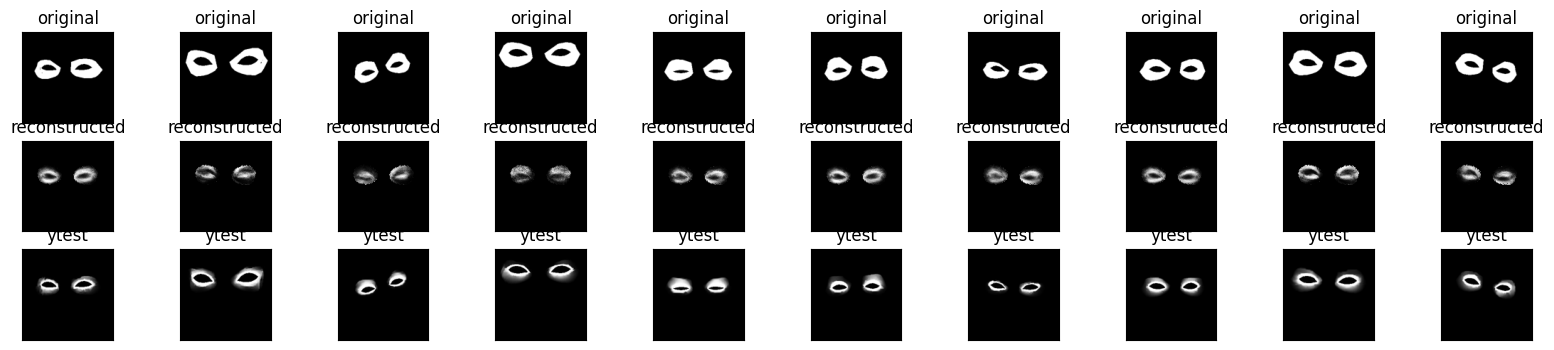

In [25]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(y_test[i])
    plt.title("ytest")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

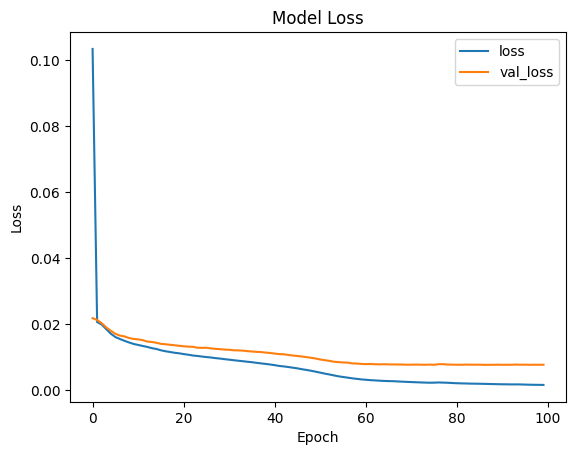

10/10 - 0s - 15ms/step - binary_io_u_2: 0.9325 - loss: 0.0078
Test accuracy: 0.9325352311134338


In [28]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(loc='upper right')
plt.show()


test_loss, test_acc = autoencoder.evaluate(x_test, y_test,verbose=2,)

print(f'Test accuracy: {test_acc}')